In [59]:
# Basic libraries
import pandas as pd
import numpy as np
import warnings
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

In [61]:
df = pd.read_csv('../data/cleaned.csv', parse_dates=['fire_dateonly_created'])
df.dropna(inplace=True)

In [63]:
df.head()

,fire_name,fire_dateonly_created,precipitation,max_temp,min_temp,avg_wind_speed,temp_range,wind_temp_ratio,lagged_precipitation,lagged_avg_wind_speed,month,season,fire_longitude,fire_latitude,fire_acres_burned,bright_t31,frp,brightness,clean_county,year
0,Bridge Fire,2017-10-31,0.0,69.0,63.0,6.04,6.0,0.087536,0.00,6.391429,10,Fall,-122.309000,40.774000,37.0,289.939315,28.226986,315.575205,Shasta County,2017
1,River Fire,2013-02-24,0.0,65.0,46.0,7.61,19.0,0.117077,0.13,8.885714,2,Winter,-118.016510,36.602575,407.0,286.600000,67.900000,321.200000,Inyo County,2013
2,Fawnskin Fire,2013-04-20,0.0,78.0,55.0,5.82,23.0,0.074615,0.06,9.332857,4,Spring,-116.941311,34.288877,30.0,294.734078,29.368715,316.384916,San Bernardino County,2013
3,Gold Fire,2013-04-30,0.0,67.0,59.0,7.61,8.0,0.113582,0.00,7.062857,4,Spring,-119.635004,37.116295,274.0,296.064780,33.913836,317.152201,Madera County,2013
4,Panther Fire,2013-05-01,0.0,71.0,61.0,7.61,10.0,0.107183,0.00,7.382857,5,Spring,-121.595555,40.190062,6896.0,313.700000,321.400000,409.300000,Tehama County,2013


 Key Feature Summary
 
🎯 Target Variable: fire_acres_burned — continuous (regression task)

🧭 Spatial: fire_latitude, fire_longitude, clean_county

📅 Temporal: fire_dateonly_created, month, season, year

🌦️ Weather: precipitation, max_temp, min_temp, avg_wind_speed, temp_range, lagged_precipitation, lagged_avg_wind_speed

🔥 Fire behavior: brightness, frp, bright_t31, wind_temp_ratio

In [66]:
# Bucket fire sizes into custom ranges
bins = [0, 10, 100, 1000, 10000, 100000, 1000000, float("inf")]
labels = [
    "0–10 acres", "11–100 acres", "101–1,000 acres", 
    "1,001–10,000 acres", "10,001–100,000 acres", 
    "100,001–1,000,000 acres", "Over 1,000,000 acres"
]

df["fire_size_bucket"] = pd.cut(df["fire_acres_burned"], bins=bins, labels=labels)

# Count the number of fires in each bucket
fire_bucket_counts = df["fire_size_bucket"].value_counts().sort_index()

# Display as DataFrame
bucket_summary = fire_bucket_counts.reset_index()
bucket_summary.columns = ["Fire Size Range", "Number of Fires"]

bucket_summary

,Fire Size Range,Number of Fires
0,0–10 acres,103
1,11–100 acres,1370
2,"101–1,000 acres",807
3,"1,001–10,000 acres",295
4,"10,001–100,000 acres",112
5,"100,001–1,000,000 acres",18
6,"Over 1,000,000 acres",1


In [68]:
len(df[df["fire_acres_burned"] < 1000])/ len(df) *100

84.10938654841094

# As 84% of number of fires is less than 1000 acres, I am considering only that category.

In [71]:
df = df[df["fire_acres_burned"] < 1000].copy()

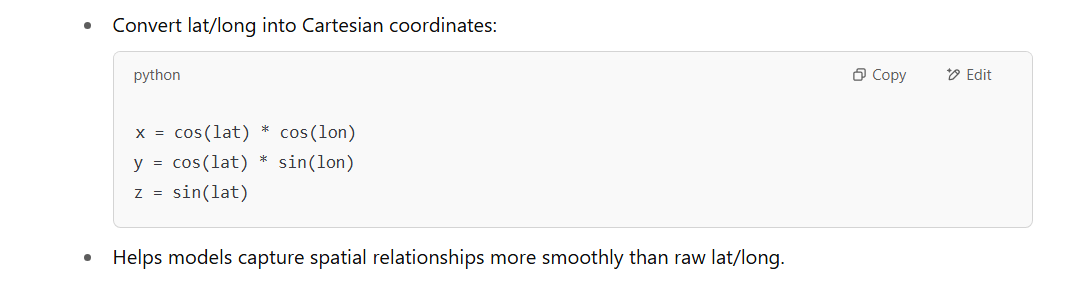

Thanks to Matt for the conversion of Latitude and Longitude coordinates insight.

In [47]:
# Drop unnecessary columns
df.drop(columns=["fire_name", "min_temp", "wind_temp_ratio", "season", "bright_t31", "year"], errors='ignore', inplace=True)

# Log-transform the target
df["log_fire_acres_burned"] = np.log1p(df["fire_acres_burned"])

# Filter top 10 counties
top_counties = df.groupby("clean_county")["fire_acres_burned"].sum().nlargest(10).index
df = df[df["clean_county"].isin(top_counties)]

# One-hot encode counties
df = pd.get_dummies(df, columns=["clean_county"], drop_first=True)

# Cartesian coordinates
df["x"] = np.cos(np.radians(df["fire_latitude"])) * np.cos(np.radians(df["fire_longitude"]))
df["y"] = np.cos(np.radians(df["fire_latitude"])) * np.sin(np.radians(df["fire_longitude"]))
df["z"] = np.sin(np.radians(df["fire_latitude"]))

# Redefine feature columns excluding 'fire_size_bucket'
feature_cols = [col for col in df.columns if col not in [
    "fire_acres_burned", "log_fire_acres_burned", "fire_dateonly_created", "fire_size_bucket", "fire_latitude", "fire_longitude"
]]
X = df[feature_cols]
y_log = df["log_fire_acres_burned"]
y_actual = df["fire_acres_burned"]

# Train-test split
X_train, X_test, y_train_log, y_test_log, y_train_actual, y_test_actual = train_test_split(
    X, y_log, y_actual, test_size=0.2, random_state=42
)

# Train and evaluate linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_log)

y_pred_train_log = lr_model.predict(X_train)
y_pred_train = np.expm1(y_pred_train_log)
mae_train = mean_absolute_error(y_train_actual, y_pred_train)

y_pred_log = lr_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
mae_test = mean_absolute_error(y_test_actual, y_pred)

mae_train, mae_test

(105.02090335315062, 112.33417326141243)

In [88]:
baseline = (y_test_actual - y_test_actual.mean()).abs().mean()
baseline

137.66836127636563

In [49]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize and train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train_log)
ridge_preds = np.expm1(ridge.predict(X_test))
mae_ridge = mean_absolute_error(y_test_actual, ridge_preds)

# Initialize and train Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train_log)
lasso_preds = np.expm1(lasso.predict(X_test))
mae_lasso = mean_absolute_error(y_test_actual, lasso_preds)

# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=200,         
    max_depth=10,             
    min_samples_split=5,      
    min_samples_leaf=2,       
    max_features='sqrt',      
    bootstrap=True,           
    random_state=42,
    n_jobs=-1                 
)
rf.fit(X_train, y_train_log)
rf_preds = np.expm1(rf.predict(X_test))
mae_rf = mean_absolute_error(y_test_actual, rf_preds)

# XGBoost Regressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train_log)
xgb_preds = np.expm1(xgb.predict(X_test))
mae_xgb = mean_absolute_error(y_test_actual, xgb_preds)

# Compile all MAE results
mae_results = {
    "Ridge Regression": mae_ridge,
    "Lasso Regression": mae_lasso,
    "Random Forest": mae_rf,
    "XGBoost": mae_xgb
}
mae_results

{'Ridge Regression': 112.33931410132469,
 'Lasso Regression': 113.95906804325375,
 'Random Forest': 108.95686490503917,
 'XGBoost': 113.5371904284455}

In [51]:
from sklearn.model_selection import GridSearchCV

# Ridge Regression Tuning
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_absolute_error', cv=3)
ridge_grid.fit(X_train, y_train_log)
best_ridge = ridge_grid.best_estimator_
mae_ridge = mean_absolute_error(y_test_actual, np.expm1(best_ridge.predict(X_test)))

# Lasso Regression Tuning
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, scoring='neg_mean_absolute_error', cv=3)
lasso_grid.fit(X_train, y_train_log)
best_lasso = lasso_grid.best_estimator_
mae_lasso = mean_absolute_error(y_test_actual, np.expm1(best_lasso.predict(X_test)))

print("Tuned Ridge MAE:", mae_ridge)
print("Tuned Lasso MAE:", mae_lasso)

Tuned Ridge MAE: 112.18447996557511
Tuned Lasso MAE: 111.71689652593419


### Model Comparison on Fire Sizes < 1,000 Acres (Test Set MAE in Acres)

| Model                 | Test MAE (acres) |
|-----------------------|------------------|
| Baseline         |  137.67 |
| Linear Regression     | 112.46 (105.03)           |
| Ridge Regression      | 112.18          |
| Lasso Regression      | 111.71           |
| Random Forest         | **108.95**       |
| XGBoost               | 114.52           |


On average, my model's predictions are off by about 109 acres.

So the average prediction error (109 acres) is 109 ÷ 1000 = 10.9% of the maximum possible fire size in this dataset.

The model is not overfitting.

It generalizes well to unseen small and medium fires.

All models outperformed the baseline, meaning they learned patterns from the input features.

Random Forest showed the best performance, reducing MAE by ~ 29 acres (~21% improvement).

The model is better equipped to handle skew (many small fires, few larger ones) since log transformed.

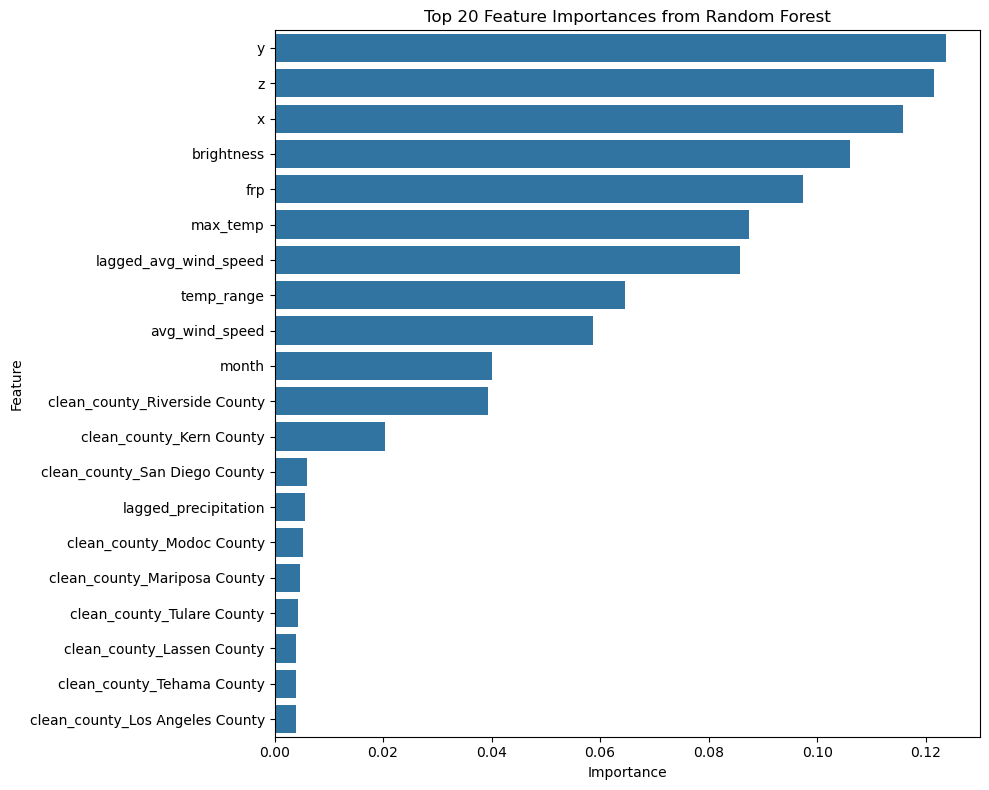

,Feature,Importance
19,y,0.123817
20,z,0.121526
18,x,0.115791
8,brightness,0.106022
7,frp,0.097442
1,max_temp,0.087426
5,lagged_avg_wind_speed,0.085726
3,temp_range,0.064609
2,avg_wind_speed,0.058668
6,month,0.040086


In [618]:
# Extract feature importances from the trained Random Forest model
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top 20 most important features
top_features = importance_df.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features, x="Importance", y="Feature")
plt.title("Top 20 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

top_features

In [620]:
county_columns = [col for col in df.columns if col.startswith("clean_county_")]
joblib.dump(county_columns, "../app/county_columns.pkl")

['../app/county_columns.pkl']

In [622]:
# Save the trained model to a file
joblib.dump(rf, "../app/random_forest_fire_model.pkl")

['../app/random_forest_fire_model.pkl']

In [624]:
# Filter out extreme fires
df = df[df["fire_acres_burned"] < 1000].copy()

# Add Cartesian coordinates
df["x"] = np.cos(np.radians(df["fire_latitude"])) * np.cos(np.radians(df["fire_longitude"]))
df["y"] = np.cos(np.radians(df["fire_latitude"])) * np.sin(np.radians(df["fire_longitude"]))
df["z"] = np.sin(np.radians(df["fire_latitude"]))

# Log-transform target
df["log_fire_acres_burned"] = np.log1p(df["fire_acres_burned"])

# Updated minimal feature set
features = ["brightness", "frp", "avg_wind_speed", "max_temp", "x", "y", "z"]
X = df[features]
y = df["log_fire_acres_burned"]

# Train model
rf_minimal_updated = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_minimal_updated.fit(X, y)

# Save model
joblib.dump(rf_minimal_updated, "../app/random_forest_fire_model_minimal_updated.pkl")

['../app/random_forest_fire_model_minimal_updated.pkl']

## Summary

- **Fire Trends Over Time**: 
  - The number of wildfires and total acres burned have increased significantly from 2000 to 2023.
  - A clear seasonal pattern was observed: **July to September** had the highest concentration of large fires.

- **Fire Size Distribution**:
  - While **most fires were small (< 1000 acres)**, a few **very large fires (> 100,000 acres)** contributed to the majority of area burned.
  - Fires larger than 1000 acres have been steadily increasing over the years.

- **Spatial Hotspots**:
  - Counties such as **Plumas, Glenn, Siskiyou, Butte, and Shasta** consistently recorded high total acreage burned, making them geographic hotspots for large-scale fires.

- **Predictive Features**:
  - The most important factors in predicting fire size were:
    - **Brightness** and **Fire Radiative Power (FRP)**: Proxy indicators of fire energy and intensity.
    - **Temperature** and **Wind Speed**: Weather conditions that affect fire spread.
    - **Latitude and Longitude (spatial features)**: Certain regions are more prone to large fires.

- **Model Performance**:
  - A **Random Forest Regressor** was trained using environmental and spatial features.
  - The model was evaluated using **Mean Absolute Error (MAE)** and was able to reasonably predict fire size in acres.
  - Smaller fires were predicted with higher accuracy, while larger fires showed more variability — a natural challenge in imbalanced datasets.

---

## Recommendations

1. **Use the model as soon as a fire is detected**  
   The model can give a quick estimate of how big a fire might get. This helps responders act faster and make better decisions.

2. **Send more help to high-risk areas**  
   Some counties (like Plumas and Siskiyou) often have large fires. More equipment and teams should be ready in these places.

3. **Be more prepared in summer and fall**  
   Most large fires happen between July and September. Extra resources should be available during these months.

4. **Educate communities in fire-prone areas**  
   People living in areas that often have big fires should be informed and trained on fire safety and evacuation.

5. **Show predictions on a live map**  
   Fire departments can use the model’s predictions in a map view to easily see where the biggest risks are and plan accordingly.

6. **Improve the model over time**  
   Add more data like wind, drought, and vegetation to make predictions even more accurate.

---

## Why It Matters to Fire Responders

- **Saves time**: Helps responders decide quickly where to go and what to do.
- **Protects lives and property**: Knowing how big a fire might get helps keep people and firefighters safer.
- **Uses resources better**: Teams and equipment can be sent where they’re needed most, not wasted on smaller fires.
- **Supports teamwork**: A clear prediction helps local, state, and national teams work together more effectively.
- **Prepares for the future**: Data and predictions help fire agencies get ready before a fire becomes a big problem.
